In [1]:
import pandas as pd
import numpy as np
import sys
def drop_duplicates(df,column='z'):
    tmp=df.copy()
    tmp['zstr']=tmp[column].astype(str)#.drop_duplicates(subset='z')
    tmp=tmp.drop_duplicates(subset='zstr')
    return tmp.drop('zstr',axis='columns')

In [2]:
REBUILD=False

In [3]:
%%writefile solutions.py
# %load solutions.py
#TODO: inherit from free class
import numpy as np
import itertools
import sys
from joblib import Parallel, delayed
from anomalies import anomaly
z=anomaly.free
import warnings
warnings.filterwarnings("ignore")
def _get_chiral(q,q_max=np.inf):
    #Normalize to positive minimum
    if q[0]<0 or (q[0]==0 and q[1]<0):
        q=-q
    #Divide by GCD
    GCD=np.gcd.reduce(q)
    q=(q/GCD).astype(int)
    if ( #not 0 in z and 
          0 not in [ sum(p) for p in itertools.permutations(q, 2) ] and #avoid vector-like and multiple 0's
          #q.size > np.unique(q).size and # check for at least a duplicated entry
          np.abs(q).max()<=q_max
           ):
        return q,GCD
    else:
        return None,None
    
def get_solution(l,k,sols=[],zmax=32):
    q,gcd=_get_chiral( z(l,k) )
    #if q is not None and np.abs(q).max()<=zmax:#
    if q is not None and np.abs(q).max()<=zmax:
        #sols.append(list(q))
        return {'l':l,'k':k,'z':list(q),'gcd':gcd}
    else:
        return {}    

def clean_sols(l,DEBUG=False):
    '''
    For the list of the dictionaries, `l` search
    the unique solutions with minimum `'gcd'` 
    
    Each dictionary must have at least the keys:
      'l','k' → solution parameters
       'z'   → solution
       'gcd' → General commun denominator of the solution
    '''
    l=[d for d in l if d]
    sols=[]
    newl=[]
    rptd=[]
    for dd in l:
        if DEBUG: print('dd →',dd)
        if dd['z'] not in sols:
            newl.append(dd)
            sols.append(dd['z'])
        elif dd['z'] in sols and dd['z'] not in rptd:
            rptd.append(dd['z'])
            if DEBUG: print('check gcd →',dd['z'])
            dmin={}
            mingcd=np.Inf
            FOUND=False
            irptd=-1
            for d in l:
                if dd['z']==d['z']: # must be also in newl
                    for i in range(len(newl)):
                        newd=newl[i]
                        if dd['z']==newd['z']:
                            if not FOUND:
                                irptd=i
                                FOUND=True
                    
                    if DEBUG: print('i →',i,irptd)
                    if DEBUG: print('   d →',d)    
                    #mingcd=dd['gcd']
                    if DEBUG: print(mingcd,dd['gcd']),abs(d['gcd'])
                    if abs( d['gcd'])<abs(dd['gcd'] ) and abs(d['gcd'])<mingcd:
                        mingcd=d['gcd']
                        if DEBUG: print('→→→',abs(dd['gcd']),abs(d['gcd']),mingcd)
                        dmin=d
            if dmin and irptd>-1:
                #Replace with solution with minimum 'gcd'
                newl[irptd]=dmin
    return newl,sols

class solutions(object):
    '''
    Obtain anomaly free solutions with N chiral fields
    
    Call the initialize object with N and get the solutions:
    Example:
    >>> s=solutions()
    >>> s(6) # N = 6
    
    Redefine the self.chiral function to implement further restrictions:
    inherit from this class and define the new chiral function
    '''
    def __init__(self,nmin=-2,nmax=2,zmax=np.inf,parallel=False,n_jobs=1,max_size=900000000):
        self.nmin=nmin
        self.nmax=nmax
        self.zmax=zmax
        self.CALL=False
        self.free=[]
        self.parallel=parallel
        self.n_jobs=n_jobs
        self.max_size=max_size


    def __call__(self,N,*args,**kwargs):
        if kwargs.get('nmin'):
            self.nmin=kwargs['nmin']
        if kwargs.get('nmax'):
            self.nmax=kwargs['nmax']            
        if kwargs.get('zmax'):
            self.zmax=kwargs['zmax']
        if kwargs.get('max_size'):
            self.max_size=kwargs['max_size']            
        self.CALL=True
        self.N=N
        if N%2!=0: #odd
            N_l=(N-3)//2
            N_k=(N-1)//2
        else: #even
            N_l=N//2-1
            N_k=N_l
        r=range(self.nmin,self.nmax+1)
        self.ls=list(itertools.product( *(r for i in range(N_l)) ))
        self.ks=list(itertools.product( *(r for i in range(N_k)) ))
        if not self.parallel:
            return self.chiral(*args,**kwargs)
        else:
            sols=[]
            kk=1
            ll=[]
            #limit for 70 jobs and 96GB of RAM
            ksmax=self.max_size
            if len(self.ls)*len(self.ks)>ksmax:
                kk=(len(self.ls)*len(self.ks)+ksmax)//ksmax
            #print('kk',kk)
            for kq in range(kk):
                if kk>1:
                    print('chunk: {}'.format(len(sols)))
                ll=ll+Parallel(n_jobs=self.n_jobs)(
                     delayed(get_solution)(l, k,sols,self.zmax) 
                     for k in self.ks for l in self.ls[len(self.ls)*kq//kk:len(self.ls)*(kq+1)//kk] )
                self.full=ll
                ll,sols=clean_sols(ll) #unique solution dict and list
            return ll
        
    def chiral(self,*args,**kwargs):
        if not self.CALL:
            sys.exit('Call the initialized object first:\n>>> s=solutions()\n>>> self(5)')
        self.list=[]
        solt=[]
        for l in self.ls:
            for k in self.ks:
                l=list(l)
                k=list(k)
                q,gcd=_get_chiral( z(l,k) )
                #print(z(l,k))
                if q is not None and list(q) not in self.list and np.abs(q).max()<=zmax:
                    self.list.append(list(q))
                    solt.append({'l':l,'k':k,'z':list(q),'gcd':gcd})
        return solt


Overwriting solutions.py


In [4]:
%%writefile run.py
#!/usr/bin/evn python3
## See anomalysolutions-class.ipynb for details
#from solutions import *
import itertools
import sys
import numpy as np
import pandas as pd

import solutions as solutions
#Private functions are not imported
_get_chiral=solutions._get_chiral
z=solutions.z
#import warnings
import time
#warnings.filterwarnings("ignore")
s=solutions.solutions(parallel=True,n_jobs=5)
st=time.time()
n=9
#l=s(n,verbose=True,print_step=500000, nmin=-10,nmax=10,zmax=32,,max_size=900000000) #6
#l =s(n,verbose=True,print_step=500000,nmin=-10,nmax=10,zmax=32,max_size= 900000000) #7
#l =s(n,verbose=True,print_step=500000,nmin=-15,nmax=15,zmax=32,max_size=900000000) #8
l =s(n,verbose=True,print_step=1000000,nmin=-9,nmax=9,zmax=32,max_size=900000000) #9
print(time.time()-st)
l=[d for d in l if d]
df=pd.DataFrame(l)
df['strz']=df['z'].astype(str)
df.drop_duplicates('strz').drop('strz',axis='columns').reset_index(drop=True).to_json('s{}.json'.format(n))

Overwriting run.py


In [5]:
if not REBUILD:
    sys.exit('Ignore this cell')
dfn=pd.read_json('s9.json')

dfn['n']=dfn['z'].apply(lambda l: 8 if l.count(0)==1 else 9)

if dfn[dfn['z'].apply(lambda l: l.count(0))>1].empty:
    print('Ready n')
    kk=dfn['z'].apply(lambda l: l.remove(0) if l.count(0)==1 else l )

assert dfn.shape[0]==dfn['z'].astype(str).unique().shape[0]

for n in [8,7,6]:
    pdfn={}
    pdfn[n]=pd.read_json('s{}.json'.format(n))

    assert pdfn[n].shape[0]==pdfn[n]['z'].astype(str).unique().shape[0]

    pdfn[n]['n']=pdfn[n]['z'].apply(lambda l: n-1 if l.count(0)==1 else n)

    if pdfn[n][pdfn[n]['z'].apply(lambda l: l.count(0))>1].empty:
        print('Ready n')
        kk=pdfn[n]['z'].apply(lambda l: l.remove(0) if l.count(0)==1 else l )
    print(n,'→',pdfn[n][pdfn[n]['n']==n].shape)
    dfn=dfn.append(pdfn[n]).reset_index(drop=True)
    
    #Reordering:
    dfn['ls']=dfn['l'].apply(lambda l: np.abs(l).max())
    dfn['ks']=dfn['k'].apply(lambda l: np.abs(l).max())
    dfn=dfn.sort_values(['ls','ks']).reset_index(drop=True)
    dfn=dfn.drop(['ls','ks'],axis='columns')
    #dfn=dfn.sort_values(['gcd']).reset_index(drop=True)
    dfn=drop_duplicates(dfn,column='z')
    print(n,'→',dfn[dfn['n']==n].shape)

SystemExit: Ignore this cell

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
if not REBUILD:
    sys.exit('Ignore this cell')
dfn[dfn['z'].apply(lambda l: l.count(0)>0)]

SystemExit: Ignore this cell

In [7]:
if not REBUILD:
    sys.exit('Ignore this cell')
rng={}
for n in [6,7,8,9]:
    rng[n]=[(dfn[dfn['n']==n].l.apply(lambda l: max(l)).max(),dfn[dfn['n']==n].l.apply(lambda l: min(l)).min()),
 (dfn[dfn['n']==n].k.apply(lambda l: max(l)).max(),dfn[dfn['n']==n].k.apply(lambda l: min(l)).min())]

SystemExit: Ignore this cell

`
{6: [(21, -21), (21, -21)],
  7: [(16, -16), (16, -16)],
  8: [(15, -15), (15, -15)],
  9: [(12, -12), (12, -12)]}
`

In [8]:
if not REBUILD:
    sys.exit('Ignore this cell')
rng

SystemExit: Ignore this cell

In [9]:
if not REBUILD:
    sys.exit('Ignore this cell')
dfn=dfn.rename(columns={'z':'solution'})
dfn.to_json('solutions.json',orient='records')

SystemExit: Ignore this cell

In [10]:
import os
if os.path.exists('/content'):
    !git clone https://github.com/restrepo/anomaly.git 2> /dev/null > /dev/null
    ! pip install anomalies 2> /dev/null > /dev/null
    os.chdir('anomaly')

Inehirate from `solutions` class to explore for solutions with repeated charges

## Find solutions with repeated charges

In [11]:
ds=pd.read_json('solutions.json')

In [12]:
ds.shape

(31211, 5)

In [13]:
ds[ds['solution'].astype(str)=='[2, -3, -10, 13, 13, -15]']

,l,k,solution,gcd,n
503,"[1, 0]","[-1, -5, 0]","[2, -3, -10, 13, 13, -15]",2,6


In [14]:
ds['strz']=ds['solution'].astype(str)
ds.drop_duplicates('strz').shape

(31211, 6)

In [15]:
ds=ds.drop('strz',axis='columns')

In [16]:
ds[ds['solution'].apply(lambda l: len(l)-len(set(l)))>0].shape[0]

16805

In [17]:
#See anomalysolutions.ipynb for details
from anomalytools import *

In [ ]:
ds=label_solutions(ds,Dim=5)
ds6=label_solutions(ds,Dim=6)
cl=filter_solution(ds,nmax=32)
cl6=filter_solution(ds6,nmax=32)
cl['DD']=cl.apply(lambda row: get_nuR(row,'DarkDirac'),axis='columns')
cl['DM']=cl.apply(lambda row: get_nuR(row,'DarkMajor'),axis='columns')
cl['XD']=cl.apply(lambda row: get_nuR(row,'XDirac'),axis='columns')
cl['XM']=cl.apply(lambda row: get_nuR(row,'XMajor'),axis='columns')
cl6['DD']=cl6.apply(lambda row: get_nuR(row,'DarkDirac',Dim=6),axis='columns')
cl6['DM']=cl6.apply(lambda row: get_nuR(row,'DarkMajor',Dim=6),axis='columns')
cl6['XD']=cl6.apply(lambda row: get_nuR(row,'XDirac',Dim=6),axis='columns')
cl6['XM']=cl6.apply(lambda row: get_nuR(row,'XMajor',Dim=6),axis='columns')

In [ ]:
REBUILD=True
if REBUILD:
    cl.to_json('cl.json')
    cl6.to_json('cl6.json')

## Filter solutions with at most two massless chiral fermions

In [ ]:
cl=pd.read_json('cl.json').reset_index(drop=True)
cl['sltn']=cl['sltn'].apply(jsonKeys2int)
cl=cl.sort_values('n').reset_index(drop=True)
cl6=pd.read_json('cl6.json').reset_index(drop=True)
cl6['sltn']=cl6['sltn'].apply(jsonKeys2int)
cl6=cl6.sort_values('n').reset_index(drop=True)

DD analysis

In [22]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth',500)

In [24]:
cl['DD_massless']=cl.apply(lambda row:   massfer(row,label='DarkDirac'),axis='columns')
cl['DM_massless']=cl.apply(lambda row:   massfer(row,label='DarkMajor'),axis='columns')
cl['XD_massless']=cl.apply(lambda row:   massfer(row,label='XDirac'   ),axis='columns')
cl['XM_massless']=cl.apply(lambda row:   massfer(row,label='XMajor'   ),axis='columns')

In [25]:
cl6['DD_massless']=cl6.apply(lambda row: massfer(row,label='DarkDirac',Dim=6),axis='columns')
cl6['DM_massless']=cl6.apply(lambda row: massfer(row,label='DarkMajor',Dim=6),axis='columns')
cl6['XD_massless']=cl6.apply(lambda row: massfer(row,label='XDirac'   ,Dim=6),axis='columns')
cl6['XM_massless']=cl6.apply(lambda row: massfer(row,label='XMajor'   ,Dim=6),axis='columns')

In [26]:
z=np.array([1,1,1,1,1,1,-4,-4,-4,-4,5,5])
z.sum(),(z**3).sum()

(0, 0)

In [27]:
cl['total']   =cl['solution'].reset_index(drop=True).apply(lambda l: np.abs( np.array(l) ).sum() )
#cl['sltn_len']=-cl['sltn'].apply(lambda d: list(itertools.chain(*d.values()))).apply(len)

In [28]:
cl6['total']   =cl6['solution'].reset_index(drop=True).apply(lambda l: np.abs( np.array(l) ).sum() )
#cl6['sltn_len']=-cl6['sltn'].apply(lambda d: list(itertools.chain(*d.values()))).apply(len)

In [29]:
row=cl[cl['solution'].astype(str)=='[1, 4, 5, 5, -8, -10, -10, 13]'].reset_index(drop=True).loc[0].to_dict()

In [30]:
sltn_intersection(row,model='DarkMajor')

2

## Filter unique solutions

Pure solutions

In [31]:
dim=[5,6]
#d=dim[0]
for d in dim:
    if d==5:
        fl=pd.DataFrame()
        clc=cl.copy()
    else:
        fl6=pd.DataFrame()
        clc=cl6.copy()
    models=pd.DataFrame([
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']==0) & (clc['XDirac']==0) & (clc['XMajor']==0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']==0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']==0) & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']>0)  & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']>0))},
         {'model':'DarkDirac','condition':((clc['DarkDirac']>0)  & (clc['DarkMajor']>0)  & (clc['XDirac']>0)  & (clc['XMajor']>0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']==0) & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']==0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']==0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']==0) & (clc['DarkMajor']>0)  & (clc['XDirac']> 0) & (clc['XMajor']==0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']==0) & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']> 0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']>0)  & (clc['XDirac']> 0) & (clc['XMajor']==0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']>0)  & (clc['XDirac']==0) & (clc['XMajor']> 0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']==0) & (clc['DarkMajor']>0)  & (clc['XDirac']> 0) & (clc['XMajor']> 0))},
         {'model':'DarkMajor','condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']>0)  & (clc['XDirac']> 0) & (clc['XMajor']> 0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']> 0) & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']> 0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']> 0) & (clc['XDirac']>0)  & (clc['XMajor']==0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']==0) & (clc['XDirac']>0)  & (clc['XMajor']> 0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']> 0) & (clc['XDirac']>0)  & (clc['XMajor']> 0))},
         {'model':'XDirac'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']> 0) & (clc['XDirac']>0)  & (clc['XMajor']> 0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']==0) & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']==0) & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']> 0) & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']==0) & (clc['XDirac']> 0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']> 0) & (clc['XDirac']==0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']==0) & (clc['XDirac']> 0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']==0) & (clc['DarkMajor']> 0) & (clc['XDirac']> 0) & (clc['XMajor']>0))},
         {'model':'XMajor'   ,'condition':((clc['DarkDirac']> 0) & (clc['DarkMajor']> 0) & (clc['XDirac']> 0) & (clc['XMajor']>0))}
    ])
    #i=0
    for i in models.index:
        mdl=models.loc[i,'model']
        tmp=clc[models.loc[i,'condition']].reset_index(drop=True)
        if not tmp.empty:
            tmp['sltn_len']=-tmp.apply(lambda row: sltn_intersection(row, model=mdl,Dim=d ) ,axis='columns')
            massless={'DarkDirac':'DD_massless','DarkMajor':'DM_massless','XDirac':'XD_massless','XMajor':'XM_massless'}
            if d==5:
                fl=fl.append(
                    tmp.sort_values(['n',massless[mdl],'sltn_len','total']
                     ).drop_duplicates(['n',massless[mdl],'sltn_len']).reset_index(drop=True)
                ).reset_index(drop=True)
                fl['str']=fl['solution'].astype(str)
                fl=fl.drop_duplicates('str').drop('str',axis='columns').reset_index(drop=True)                 
            if d==6:
                fl6=fl6.append(
                    tmp.sort_values(['n',massless[mdl],'sltn_len','total']
                     ).drop_duplicates(['n',massless[mdl],'sltn_len']).reset_index(drop=True)
                ).reset_index(drop=True)
                fl6['str']=fl6['solution'].astype(str)
                fl6=fl6.drop_duplicates('str').drop('str',axis='columns').reset_index(drop=True)                                 

In [32]:
cl[cl['solution'].astype(str)=='[5, 5, 7, -8, -12, -12, 15]']

,l,k,solution,gcd,n,nu_R,DarkDirac,DarkMajor,XDirac,XMajor,sltn,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total
59,"[-1, 0, -1]","[-3, 1, 0]","[5, 5, 7, -8, -12, -12, 15]",1,7,"[{'D→nu_R+fi+fj': [-12, 5, 7]}]",1,0,0,0,"{2: [5, -12]}","[-12, 5]",0,0,0,3,10,10,10,64


In [33]:
cl.shape

(6754, 20)

In [34]:
cl[cl['solution'].astype(str)=='[2, -3, -10, 13, 13, -15]']

,l,k,solution,gcd,n,nu_R,DarkDirac,DarkMajor,XDirac,XMajor,sltn,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total
2,"[1, 0]","[-1, -5, 0]","[2, -3, -10, 13, 13, -15]",2,6,"[{'D→nu_R+fi+fj': [-15, 2, 13]}, {'D→nu_R+fi+fj': [-10, -3, 13]}]",2,0,0,0,{2: [13]},[13],0,0,0,0,10,10,10,56


In [35]:
fl=fl[fl.apply(lambda r:min([r['DD_massless'],r['DM_massless'],r['XM_massless'],r['XD_massless']])<=2,axis='columns' )
     ].sort_values(['n',massless[mdl],'sltn_len','total'])[
       ['n','l','k','gcd','solution','DD', 'DM', 'XD', 'XM', 'DD_massless',
       'DM_massless','XD_massless', 'XM_massless','total','sltn_len','nu_R']].reset_index(drop=True)
fl

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R
0,6,"[-1, 1]","[-2, 0]",1,"[1, -2, -3, 5, 5, -6]",[5],0,0,0,0,10,10,10,22,-1,"[{'D→nu_R+fi+fj': [-6, 1, 5]}, {'D→nu_R+fi+fj': [-3, -2, 5]}]"
1,7,"[-1, 1]","[-1, 0, -1]",1,"[1, 2, 2, -3, -3, -3, 4]",[-3],0,0,0,2,10,10,10,18,-2,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]"
2,7,"[1, -1]","[-2, -5, -4]",1,"[1, 1, -3, -4, 6, 6, -7]","[1, 6]",[6],0,0,2,2,10,10,28,-2,"[{'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+2fi': [6, -3]}]"
3,7,"[-2, 0]","[-1, -2, -1]",1,"[2, 3, 3, -4, -5, -6, 7]",[3],0,0,0,1,10,10,10,30,-1,"[{'D→nu_R+fi+fj': [-5, 2, 3]}]"
4,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],[-6],0,0,2,2,10,10,32,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]"
5,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",[1],0,0,0,2,10,10,10,34,-1,"[{'D→nu_R+fi+fj': [-9, 1, 8]}]"
6,8,"[-1, -5, -3]","[-6, -4, -7]",1,"[1, 1, 2, 3, -4, -4, -5, 6]","[-4, 1]",[-4],0,0,2,2,10,10,26,-2,"[{'D→nu_R+fi+fj': [-4, 1, 3]}, {'D→nu_R+2fi': [-4, 2]}]"
7,8,"[1, 4, 3]","[-2, -3, -4]",2,"[2, 4, 4, 5, -9, -9, -10, 13]","[-9, 4]",0,0,0,2,10,10,10,56,-2,"[{'D→nu_R+fi+fj': [-9, 4, 5]}]"
8,8,"[-1, 2, -2]","[-7, 4, 0]",1,"[1, 2, 2, 2, -3, -5, -6, 7]",[2],0,0,0,1,10,10,10,28,-1,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]"
9,8,"[1, 2, 1]","[-5, -10, -11]",1,"[1, 2, 2, 4, -5, -5, -7, 8]",[-5],0,0,0,2,10,10,10,34,-1,"[{'D→nu_R+fi+fj': [-5, 1, 4]}]"


In [36]:
np.sort( fl['solution'].apply(lambda l: np.abs(l).max()).unique() ).max()

28

In [37]:
fl6=fl6[fl6.apply(lambda r:min([r['DD_massless'],r['DM_massless'],r['XM_massless'],r['XD_massless']])<=2,axis='columns' )
       ].sort_values(['n',massless[mdl],'sltn_len','total'])[
       ['n','l','k','gcd','solution','DD', 'DM', 'XD', 'XM', 'DD_massless',
       'DM_massless','XD_massless', 'XM_massless','total','sltn_len','nu_R']].reset_index(drop=True)

In [38]:
fl6

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R
0,6,"[-1, -2]","[-1, 2]",1,"[1, 1, 1, -4, -4, 5]",0,[-4],0,0,10,1,10,10,16,-2,"[{'D→nu_R+4fi': [-4, 1]}]"
1,6,"[1, -2]","[-4, 1]",3,"[1, -4, -4, 9, 9, -11]",0,[-4],0,0,10,1,10,10,38,-1,"[{'D→nu_R+4fi': [-4, 1]}]"
2,6,"[2, 1]","[-2, -1, 0]",1,"[1, -4, -8, 14, 14, -17]",[14],0,0,0,2,10,10,10,58,-1,"[{'D→nu_R+2fi+2fj': [-8, 1, 14]}]"
3,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",0,[-4],0,0,10,1,10,10,34,-2,"[{'D→nu_R+4fi': [-4, 1]}]"
4,7,"[3, 1]","[-1, -5, 7]",1,"[2, 2, -4, 7, -8, -8, 9]",[2],[-8],0,0,2,3,10,10,40,-2,"[{'D→nu_R+2fi+2fj': [-8, 2, 7]}, {'D→nu_R+4fi': [-8, 2]}]"
5,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],0,0,0,2,10,10,10,32,-1,"[{'D→nu_R+2fi+2fj': [-6, -4, 7]}]"
6,7,"[-3, -1]","[-2, -3, 1]",1,"[3, 3, 3, -5, -5, -7, 8]",0,0,[-5],0,10,10,0,10,34,-1,"[{'X→nu_R+2fi+2fj': [-7, -5, 8]}]"
7,7,"[-3, -4]","[-5, -7, -4]",2,"[4, 4, 5, -7, -8, -9, 11]",[4],0,0,0,1,10,10,10,48,-1,"[{'D→nu_R+2fi+2fj': [-7, 4, 5]}]"
8,7,"[-1, -2]","[-8, -6, -7]",16,"[7, 10, -18, 25, -28, -28, 32]",[-28],[-28],0,0,2,2,10,10,148,-1,"[{'D→nu_R+4fi': [-28, 7]}, {'D→nu_R+2fi+2fj': [-28, -18, 32]}]"
9,8,"[1, -3, -2]","[-4, -9, -5, -3]",1,"[1, 3, 3, 3, -5, -7, -7, 9]",0,0,0,[-7],10,10,10,2,38,-1,"[{'X→nu_R+4fi': [-7, 1]}]"


In [39]:
np.sort( fl6['solution'].apply(lambda l: np.abs(l).max()).unique() ).max()

32

In [40]:
n=9
x=1
fl6[(fl6['n']==n) & (fl6['XD_massless']==x)].sort_values(['DD_massless','DM_massless','XM_massless'],ascending=False)

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R
46,9,"[-2, 1, 2]","[-6, -8, 7, 6]",2,"[4, 4, 4, 5, -6, -6, -6, -10, 11]",0,0,"[4, -6]",0,10,10,1,10,56,-1,"[{'X→nu_R+2fi+2fj': [-10, -6, 11]}, {'X→nu_R+2fi+2fj': [-10, 4, 11]}]"
25,9,"[-2, 6, -4]","[-8, -7, 6, 3]",20,"[3, 3, 3, 5, -16, 22, -23, -23, 26]",0,0,[-23],[-23],10,10,1,1,124,-1,"[{'X→nu_R+4fi': [-23, 5]}, {'X→nu_R+2fi+2fj': [-23, -16, 26]}]"
40,9,"[-6, -3, 5]","[-4, -2, -6, 8]",4,"[4, 7, -8, 9, -16, -16, -16, 18, 18]",[18],[-16],[18],0,3,4,1,10,112,-2,"[{'D→nu_R+2fi+2fj': [-16, 7, 18]}, {'D→nu_R+4fi': [-16, 4]}, {'X→nu_R+2fi+2fj': [-8, 7, 18]}]"


In [41]:
np.sort( fl6['solution'].apply(lambda l: np.abs(l).max()).unique() ).max()

32

In [42]:
import re
def add_boldsymbol(ss):
    if str(ss).find(r'\boldsymbol')==-1:
        return re.sub('(\-*[0-9]+)',r'\\boldsymbol{\1}',str(ss))
    else:
        return ss

In [104]:
kk=fl6.copy()
#kk=fl6.copy()
for i in kk.index:
#if True:
#    i=6
    for s in ['DD','DM','XD','XM']:
        if kk.loc[i,'{}_massless'.format(s)]==0:
            kk.loc[i,'n']=add_boldsymbol(kk.loc[i,'n'])
            kk.loc[i,s]  =add_boldsymbol(kk.loc[i,s])    
#kk=fl[['n','l','k','solution','n','DD','DM','XD','XM']]
kk['Ref']=''
kk['DD']=kk['DD'].apply(lambda x: x if x!=0 else '')
kk['DM']=kk['DM'].apply(lambda x: x if x!=0 else '')
kk['XD']=kk['XD'].apply(lambda x: x if x!=0 else '')
kk['XM']=kk['XM'].apply(lambda x: x if x!=0 else '')
kkk=kk[['n','l','k','solution','gcd','Ref','DD','DM','XD','XM']]
def f(x):
    return  r'{}'.format(str(x).replace('[','(').replace(']',')'))

kkk.to_latex('solutions.tex',index=False,formatters=dict( [(k,f) for k in kk.columns ]) ,escape=False  )

In [105]:
kk

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,Ref
0,6,"[-1, -2]","[-1, 2]",1,"[1, 1, 1, -4, -4, 5]",,[-4],,,10,1,10,10,16,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,
1,6,"[1, -2]","[-4, 1]",3,"[1, -4, -4, 9, 9, -11]",,[-4],,,10,1,10,10,38,-1,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,
2,6,"[2, 1]","[-2, -1, 0]",1,"[1, -4, -8, 14, 14, -17]",[14],,,,2,10,10,10,58,-1,"[{'D→nu_R+2fi+2fj': [-8, 1, 14]}]",False,1,
3,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",,[-4],,,10,1,10,10,34,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,
4,7,"[3, 1]","[-1, -5, 7]",1,"[2, 2, -4, 7, -8, -8, 9]",[2],[-8],,,2,3,10,10,40,-2,"[{'D→nu_R+2fi+2fj': [-8, 2, 7]}, {'D→nu_R+4fi': [-8, 2]}]",False,1,
5,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],,,,2,10,10,10,32,-1,"[{'D→nu_R+2fi+2fj': [-6, -4, 7]}]",True,0,
6,\boldsymbol{7},"[-3, -1]","[-2, -3, 1]",1,"[3, 3, 3, -5, -5, -7, 8]",,,[\boldsymbol{-5}],,10,10,0,10,34,-1,"[{'X→nu_R+2fi+2fj': [-7, -5, 8]}]",False,1,
7,7,"[-3, -4]","[-5, -7, -4]",2,"[4, 4, 5, -7, -8, -9, 11]",[4],,,,1,10,10,10,48,-1,"[{'D→nu_R+2fi+2fj': [-7, 4, 5]}]",False,1,
8,7,"[-1, -2]","[-8, -6, -7]",16,"[7, 10, -18, 25, -28, -28, 32]",[-28],[-28],,,2,2,10,10,148,-1,"[{'D→nu_R+4fi': [-28, 7]}, {'D→nu_R+2fi+2fj': [-28, -18, 32]}]",False,1,
9,8,"[1, -3, -2]","[-4, -9, -5, -3]",1,"[1, 3, 3, 3, -5, -7, -7, 9]",,,,[-7],10,10,10,2,38,-1,"[{'X→nu_R+4fi': [-7, 1]}]",True,0,


In [96]:
n=r'\boldsymbol{9}'
x=0
kk[(kk['n']==n) & (kk['DD_massless']==x)]

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,Ref
17,\boldsymbol{9},"[-2, 0, 2]","[-1, 1, 0, -1]",1,"[1, 1, -4, -5, 9, 9, 9, -10, -10]",[\boldsymbol{9}],0,0,[1],0,10,10,2,58,-3,"[{'D→nu_R+fi+fj': [-10, 1, 9]}, {'D→nu_R+fi+fj': [-5, -4, 9]}, {'X→nu_R+2fi': [1, -5]}]",False,1,
20,\boldsymbol{9},"[-1, 0, 1]","[-1, -3, 0, -1]",1,"[1, 1, -3, -8, 11, 11, 11, -12, -12]",[\boldsymbol{11}],0,0,0,0,10,10,10,70,-3,"[{'D→nu_R+fi+fj': [-12, 1, 11]}, {'D→nu_R+fi+fj': [-8, -3, 11]}]",False,0,
29,\boldsymbol{9},"[-2, 3, 2]","[-2, -9, -5, 9]",1,"[1, -2, 3, 4, 6, -7, -7, -7, 9]",[\boldsymbol{-7}],0,0,0,0,10,10,10,46,-1,"[{'D→nu_R+fi+fj': [-7, -2, 9]}, {'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+fi+fj': [-7, 3, 4]}]",False,1,
31,\boldsymbol{9},"[-8, -7, 5]","[-9, 3, -4, -2]",1,"[1, -2, -2, -2, 5, -7, 8, 9, -10]",[\boldsymbol{-2}],[\boldsymbol{-2}],0,0,0,0,10,10,46,-1,"[{'D→nu_R+2fi': [-2, 1]}, {'D→nu_R+fi+fj': [-7, -2, 9]}]",False,1,


## Manual analysis

In [46]:
def extract_multiplets(l):
    xc=[]
    xr=0
    for x in l:
        if l.count(x)>1:
            if xr!=x:
                xc.append((x,l.count(x)))
                xr=x
    return xc
def extra_multiplets(row,slt='DD'):
    extramax=0
    for ν in row.get(slt):
        extra=0
        l=row.get('solution').copy()
        if l.count(ν)>2:
            extra=extra+0.25
        l=extract(l,ν)
        if slt=='XD' or slt=='XM':
            #Remove SM charges
            ms=[ x[0] for x in extract_multiplets(l) if x[-1]==3]
            if not ms:
                sys.exit('Bad X-solution → {}'.format(row['solution']))
            if len(ms)>2:
                sys.exit('NO 3 triplets yet implemented')
            l=extract(l,ms[0])
        em=extract_multiplets(l)            
        extra=extra+sum( [ x[-1] for x in em ] )
        if extra>extramax:
                extramax=extra
    return extramax

def get_score(fl,s='DD_massless',i=1):
    tmp=fl[fl[s]==i].reset_index(drop=True)
    if not tmp.empty:
        tmp['score']=tmp.apply(lambda row: extra_multiplets(row,slt=s.split('_')[0]),axis='columns')
    return tmp



def get_unstable(row):
    snu={'D→nu_R+fi+fj'  :'DD','D→nu_R+2fi':'DM','X→nu_R+fi+fj'  :'XD','X→nu_R+2fi':'XM',
         'D→nu_R+2fi+2fj':'DD','D→nu_R+4fi':'DM','X→nu_R+2fi+2fj':'XD','X→nu_R+4fi':'XM'}    
    for d in row['nu_R']:
        k=list(d.keys())[0]
        for ν in row.get( snu[k] ):
            ls=row['solution'].copy()
            l=list(d.values())[0].copy()
            #print(ν,l,ls)
            l=extract(l,ν)
            ls=extract(ls,ν)
            #print( "***",l,ls )
            if k.find('X→')>-1:
                m=[ x for x in ls if ls.count(x)==3][0]
                ls=extract(ls,m)
                #print('ls',ls)                
            if len(l)==2:
                s=sum(l)                    
                if 0 in np.array(ls)+ν-s or 0 in np.array(ls)+ν+s:
                    return True
            elif len(l)==1:
                s=sum(l)*2                    
                if 0 in np.array(ls)+ν-s or 0 in np.array(ls)+ν+s:
                    return True                   
            else:
                print('WARNING bad solition in {}'.format(row['solution']))
    return False        

In [47]:
assert extra_multiplets({'solution':[2,2,2,3,3,3,4,4,4,8,8],'XD':[2]},slt='XD')==5.25
assert extra_multiplets({'solution':[2,2,2,3,3,3,4,4,4,8,8],'DD':[2]},slt='DD')==8.25
assert extra_multiplets({'solution':[2, 2, 2, -3, -3, 4, -5, -5, 6],'XD':[-5,-3]},slt='XD')==2

In [48]:
assert not get_unstable(fl[fl['solution'].astype(str)=='[4, 4, 4, -5, -9, -10, -10, 11, 11]'].iloc[-1])
assert not get_unstable(fl[fl['solution'].astype(str)=='[2, -5, -7, -7, 10, 10, 10, -13]'].iloc[-1])
assert get_unstable(fl6[fl6['solution'].astype(str)=='[2, 2, -3, 5, -6, 7, -8, -9, 10]'].iloc[-1])

In [49]:
fl['unstable']=fl.apply( lambda row: get_unstable(row) ,axis='columns')
fl6['unstable']=fl6.apply( lambda row: get_unstable(row) ,axis='columns')

WARNING bad solition in [4, 4, -9, 11, -13, -13, 18, 18, -20]
WARNING bad solition in [4, 4, 4, 5, -6, -6, -6, -10, 11]


In [50]:
fl['Q']=1
i=0
iq=fl[fl['solution'].astype(str)=='[1, 1, -3, -8, 11, 11, 11, -12, -12]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,6,"[-1, 1]","[-2, 0]",1,"[1, -2, -3, 5, 5, -6]",[5],0,0,0,0,10,10,10,22,-1,"[{'D→nu_R+fi+fj': [-6, 1, 5]}, {'D→nu_R+fi+fj': [-3, -2, 5]}]",False,1,0.00
4,9,"[-8, -7, 5]","[-9, 3, -4, -2]",1,"[1, -2, -2, -2, 5, -7, 8, 9, -10]",[-2],[-2],0,0,0,0,10,10,46,-1,"[{'D→nu_R+2fi': [-2, 1]}, {'D→nu_R+fi+fj': [-7, -2, 9]}]",False,1,0.25
1,9,"[-2, 0, 2]","[-1, 1, 0, -1]",1,"[1, 1, -4, -5, 9, 9, 9, -10, -10]",[9],0,0,[1],0,10,10,2,58,-3,"[{'D→nu_R+fi+fj': [-10, 1, 9]}, {'D→nu_R+fi+fj': [-5, -4, 9]}, {'X→nu_R+2fi': [1, -5]}]",False,1,4.25
2,9,"[-1, 0, 1]","[-1, -3, 0, -1]",1,"[1, 1, -3, -8, 11, 11, 11, -12, -12]",[11],0,0,0,0,10,10,10,70,-3,"[{'D→nu_R+fi+fj': [-12, 1, 11]}, {'D→nu_R+fi+fj': [-8, -3, 11]}]",False,0,4.25
3,9,"[-2, 3, 2]","[-2, -9, -5, 9]",1,"[1, -2, 3, 4, 6, -7, -7, -7, 9]",[-7],0,0,0,0,10,10,10,46,-1,"[{'D→nu_R+fi+fj': [-7, -2, 9]}, {'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+fi+fj': [-7, 3, 4]}]",False,1,0.25


In [51]:
get_score(fl,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])   

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,9,"[-8, -7, 5]","[-9, 3, -4, -2]",1,"[1, -2, -2, -2, 5, -7, 8, 9, -10]",[-2],[-2],0,0,0,0,10,10,46,-1,"[{'D→nu_R+2fi': [-2, 1]}, {'D→nu_R+fi+fj': [-7, -2, 9]}]",False,1,0.25


In [52]:
iq=fl[fl['solution'].astype(str)=='[5, 6, 6, 6, -8, -9, -9, -10, 13]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,8,"[1, -3, -2]","[-4, -9, -5, -3]",1,"[1, 3, 3, 3, -5, -7, -7, 9]",0,0,[-7],0,10,10,0,10,38,-1,"[{'X→nu_R+fi+fj': [-7, -5, 9]}]",False,1,0
1,9,"[-4, 2, -3]","[-2, -5, 5, -6]",2,"[1, 2, -6, -6, -6, 8, 9, 9, -11]",[9],0,[9],0,1,10,0,10,58,-1,"[{'D→nu_R+fi+fj': [-11, 2, 9]}, {'X→nu_R+fi+fj': [-11, 8, 9]}]",False,1,0
2,9,"[-2, -1, 0]","[-1, -3, -5, -3]",2,"[5, 6, 6, 6, -8, -9, -9, -10, 13]",0,0,[-9],0,10,10,0,10,72,-1,"[{'X→nu_R+fi+fj': [-10, -9, 13]}]",False,0,0


In [53]:
get_score(fl,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q


In [54]:
#fl['Q']=1
iq=fl[fl['solution'].astype(str)=='[2, 3, 3, -4, -5, -6, 7]'].index[0]
fl.loc[iq,'Q']=0
i=1
get_score(fl,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,7,"[-2, 0]","[-1, -2, -1]",1,"[2, 3, 3, -4, -5, -6, 7]",[3],0,0,0,1,10,10,10,30,-1,"[{'D→nu_R+fi+fj': [-5, 2, 3]}]",True,0,0.00
2,8,"[-4, -1, 0]","[-1, 0, -8, 8]",1,"[3, -4, -5, 8, 8, -11, -12, 13]",[8],[8],0,0,1,1,10,10,64,-1,"[{'D→nu_R+2fi': [8, -4]}, {'D→nu_R+fi+fj': [-11, 3, 8]}]",False,1,0.00
1,8,"[-1, 2, -2]","[-7, 4, 0]",1,"[1, 2, 2, 2, -3, -5, -6, 7]",[2],0,0,0,1,10,10,10,28,-1,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]",False,1,0.25
7,9,"[1, -1, 2]","[-2, -1, 0, -2]",1,"[2, -3, 4, 6, 6, -7, -10, -11, 13]",[6],[6],0,0,1,1,10,10,62,-1,"[{'D→nu_R+2fi': [6, -3]}, {'D→nu_R+fi+fj': [-10, 4, 6]}]",False,1,0.00
4,9,"[-2, -6, 5]","[-5, -1, -3, -6]",1,"[1, 1, 2, 2, 3, -5, -6, -6, 8]",[2],[-6],0,0,1,4,10,10,34,-1,"[{'D→nu_R+fi+fj': [-5, 2, 3]}, {'D→nu_R+2fi': [-6, 3]}]",False,1,4.00
6,9,"[-4, 2, -3]","[-2, -5, 5, -6]",2,"[1, 2, -6, -6, -6, 8, 9, 9, -11]",[9],0,[9],0,1,10,0,10,58,-1,"[{'D→nu_R+fi+fj': [-11, 2, 9]}, {'X→nu_R+fi+fj': [-11, 8, 9]}]",False,1,3.00
3,9,"[-1, 0, 1]","[-1, 1, -2, -1]",1,"[1, -3, -3, -3, -5, 8, 8, 8, -11]","[-3, 8]",0,0,0,1,10,10,10,50,-2,"[{'D→nu_R+fi+fj': [-5, -3, 8]}]",False,1,3.25
5,9,"[-3, 1, -2]","[-4, -3, -6, -3]",1,"[2, -3, -3, -3, -5, 7, 7, 8, -10]",[-3],0,0,0,1,10,10,10,48,-1,"[{'D→nu_R+fi+fj': [-5, -3, 8]}]",False,1,2.25


In [55]:
get_score(fl,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,8,"[-4, -1, 0]","[-1, 0, -8, 8]",1,"[3, -4, -5, 8, 8, -11, -12, 13]",[8],[8],0,0,1,1,10,10,64,-1,"[{'D→nu_R+2fi': [8, -4]}, {'D→nu_R+fi+fj': [-11, 3, 8]}]",False,1,0
1,9,"[1, -1, 2]","[-2, -1, 0, -2]",1,"[2, -3, 4, 6, 6, -7, -10, -11, 13]",[6],[6],0,0,1,1,10,10,62,-1,"[{'D→nu_R+2fi': [6, -3]}, {'D→nu_R+fi+fj': [-10, 4, 6]}]",False,1,0
2,9,"[-4, 1, 2]","[-1, -4, 2, 1]",2,"[1, -2, -2, -3, -3, -3, 14, 20, -22]",0,[-2],0,0,10,1,10,10,70,-1,"[{'D→nu_R+2fi': [-2, 1]}]",False,1,3


In [56]:
iq=fl[fl['solution'].astype(str)=='[2, -5, -7, -7, 10, 10, 10, -13]'].index[0]
fl.loc[iq,'Q']=0
iq=fl[fl['solution'].astype(str)=='[2, 2, 2, -3, -3, 4, -5, -5, 6]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,8,"[-1, 0, -1]","[-2, 1, -1]",1,"[2, -5, -5, -5, 7, 8, 8, -10]",[8],0,[8],0,2,10,1,10,50,-1,"[{'D→nu_R+fi+fj': [-10, 2, 8]}, {'X→nu_R+fi+fj': [-10, 7, 8]}]",False,1,0
2,8,"[0, -1, 0]","[-1, -2, 2, -2]",1,"[2, -5, -7, -7, 10, 10, 10, -13]",0,[10],[-7],0,10,3,1,10,64,-1,"[{'D→nu_R+2fi': [10, -5]}, {'X→nu_R+fi+fj': [-7, -5, 2]}]",False,0,0
1,8,"[0, -1, 0]","[-1, -5, -1, 1]",2,"[1, 1, 1, -5, -7, 11, 11, -13]",0,0,[11],0,10,10,1,10,50,-1,"[{'X→nu_R+fi+fj': [-7, -5, 11]}]",False,1,0
3,9,"[2, -6, -7]","[-1, -9, -3, -6]",1,"[2, 2, 2, -3, -3, 4, -5, -5, 6]",0,0,"[-5, -3]",0,10,10,1,10,32,-2,"[{'X→nu_R+fi+fj': [-5, -3, 6]}]",True,0,2
4,9,"[-2, -1, -3]","[-1, -4, -3, -4]",1,"[4, 4, 6, 6, -7, -7, -7, -12, 13]",0,0,[6],0,10,10,1,10,66,-1,"[{'X→nu_R+fi+fj': [-12, 6, 13]}]",False,1,2


In [57]:
get_score(fl,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q


In [58]:
i=2
iq=fl[fl['solution'].astype(str)=='[1, 1, -4, -4, 7, 8, -9]'].index[0]
fl.loc[iq,'Q']=0
iq=fl[fl['solution'].astype(str)=='[2, 4, 4, 5, -9, -9, -10, 13]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
1,7,"[1, -1]","[-2, -5, -4]",1,"[1, 1, -3, -4, 6, 6, -7]","[1, 6]",[6],0,0,2,2,10,10,28,-2,"[{'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+2fi': [6, -3]}]",False,1,2.00
2,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],[-6],0,0,2,2,10,10,32,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1,0.00
0,7,"[-1, 1]","[-1, 0, -1]",1,"[1, 2, 2, -3, -3, -3, 4]",[-3],0,0,0,2,10,10,10,18,-2,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]",False,1,2.25
3,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",[1],0,0,0,2,10,10,10,34,-1,"[{'D→nu_R+fi+fj': [-9, 1, 8]}]",False,0,2.00
4,8,"[-1, -5, -3]","[-6, -4, -7]",1,"[1, 1, 2, 3, -4, -4, -5, 6]","[-4, 1]",[-4],0,0,2,2,10,10,26,-2,"[{'D→nu_R+fi+fj': [-4, 1, 3]}, {'D→nu_R+2fi': [-4, 2]}]",False,1,2.00
7,8,"[2, -1, 0]","[-5, -9, -1, 0]",1,"[1, 2, 3, 5, -6, -6, -9, 10]",[-6],[-6],0,0,2,2,10,10,42,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1,0.00
8,8,"[-1, 0, -1]","[-2, 1, -1]",1,"[2, -5, -5, -5, 7, 8, 8, -10]",[8],0,[8],0,2,10,1,10,50,-1,"[{'D→nu_R+fi+fj': [-10, 2, 8]}, {'X→nu_R+fi+fj': [-10, 7, 8]}]",False,1,3.00
5,8,"[1, 4, 3]","[-2, -3, -4]",2,"[2, 4, 4, 5, -9, -9, -10, 13]","[-9, 4]",0,0,0,2,10,10,10,56,-2,"[{'D→nu_R+fi+fj': [-9, 4, 5]}]",False,0,2.00
6,8,"[1, 2, 1]","[-5, -10, -11]",1,"[1, 2, 2, 4, -5, -5, -7, 8]",[-5],0,0,0,2,10,10,10,34,-1,"[{'D→nu_R+fi+fj': [-5, 1, 4]}]",False,1,2.00
10,9,"[5, 0, 1]","[-1, -2, 0, 2]",3,"[1, 1, -5, -7, 12, 14, 14, -15, -15]","[-15, 1, 14]",[14],0,0,2,2,10,10,84,-3,"[{'D→nu_R+fi+fj': [-15, 1, 14]}, {'D→nu_R+2fi': [14, -7]}]",False,1,4.00


In [59]:
iq=fl[fl['solution'].astype(str)=='[4, -8, -8, 11, -12, 14, 21, -22]'].index[0]
fl.loc[iq,'Q']=0
iq=fl[fl['solution'].astype(str)=='[1, 1, 2, 3, 4, -6, -6, -10, 11]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,7,"[1, -1]","[-2, -5, -4]",1,"[1, 1, -3, -4, 6, 6, -7]","[1, 6]",[6],0,0,2,2,10,10,28,-2,"[{'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+2fi': [6, -3]}]",False,1,2
1,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],[-6],0,0,2,2,10,10,32,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1,0
2,8,"[-1, -5, -3]","[-6, -4, -7]",1,"[1, 1, 2, 3, -4, -4, -5, 6]","[-4, 1]",[-4],0,0,2,2,10,10,26,-2,"[{'D→nu_R+fi+fj': [-4, 1, 3]}, {'D→nu_R+2fi': [-4, 2]}]",False,1,2
3,8,"[2, -1, 0]","[-5, -9, -1, 0]",1,"[1, 2, 3, 5, -6, -6, -9, 10]",[-6],[-6],0,0,2,2,10,10,42,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1,0
4,8,"[1, -3, -2]","[-1, -4, 2, 0]",2,"[4, -8, -8, 11, -12, 14, 21, -22]",0,[-8],0,0,10,2,10,10,100,-1,"[{'D→nu_R+2fi': [-8, 4]}]",False,0,0
5,9,"[5, 0, 1]","[-1, -2, 0, 2]",3,"[1, 1, -5, -7, 12, 14, 14, -15, -15]","[-15, 1, 14]",[14],0,0,2,2,10,10,84,-3,"[{'D→nu_R+fi+fj': [-15, 1, 14]}, {'D→nu_R+2fi': [14, -7]}]",False,1,4
6,9,"[-7, -5, 3]","[-6, -4, -5, 2]",1,"[1, -2, -2, -4, 7, -9, 11, 11, -13]","[-2, 11]",[-2],0,0,2,2,10,10,60,-2,"[{'D→nu_R+2fi': [-2, 1]}, {'D→nu_R+fi+fj': [-9, -2, 11]}]",False,1,2
7,9,"[1, 6, -3]","[-5, -4, 1, -2]",1,"[1, 1, 2, 3, 4, -6, -6, -10, 11]",[-6],[-6],0,0,2,2,10,10,44,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 2, 4]}]",False,0,2
8,9,"[1, 4, 7]","[-1, 6, 4, -5]",4,"[1, -2, -2, 5, -7, -7, 14, 18, -20]",0,[-2],0,0,10,2,10,10,76,-1,"[{'D→nu_R+2fi': [-2, 1]}]",False,1,2


In [60]:
iq=fl[fl['solution'].astype(str)=='[1, -2, -2, -2, 5, -16, 17, 17, -18]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
3,9,"[2, -1, -2]","[-1, -6, -1, -6]",2,"[1, -2, -2, -2, 5, -16, 17, 17, -18]",[17],[-2],[17],0,3,4,2,10,80,-1,"[{'D→nu_R+fi+fj': [-18, 1, 17]}, {'D→nu_R+2fi': [-2, 1]}, {'X→nu_R+fi+fj': [-16, 1, 17]}]",False,0,0
1,9,"[-4, -1, -4]","[-3, -5, 1, -4]",1,"[2, -3, 4, 4, 4, -6, -7, -7, 9]",[4],0,[-7],0,3,10,2,10,46,-1,"[{'D→nu_R+fi+fj': [-6, 2, 4]}, {'X→nu_R+fi+fj': [-7, -6, 9]}]",False,1,0
4,9,"[8, -1, 0]","[-1, -6, -3, -6]",18,"[1, 9, -12, -21, -21, 24, 24, 24, -28]",0,[24],[-21],0,10,4,2,10,164,-1,"[{'D→nu_R+2fi': [24, -12]}, {'X→nu_R+fi+fj': [-21, -12, 9]}]",False,1,0
0,9,"[3, -2, 3]","[-2, -1, -2, 4]",1,"[4, 4, 4, -5, -9, -10, -10, 11, 11]",0,0,"[-10, 11]",0,10,10,2,10,68,-2,"[{'X→nu_R+fi+fj': [-10, -5, 11]}]",False,1,2
2,9,"[-3, 6, 5]","[-1, -6, 2, -7]",2,"[2, -3, -3, -3, -6, 7, 7, 11, -12]",0,0,[7],0,10,10,2,10,54,-1,"[{'X→nu_R+fi+fj': [-6, 2, 7]}]",False,1,0


In [61]:
iq=fl[fl['solution'].astype(str)=='[1, 13, 13, -15, -15, -15, -16, 17, 17]'].index[0]
fl.loc[iq,'Q']=0
get_score(fl,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,9,"[-2, 0, 2]","[-1, 1, 0, -1]",1,"[1, 1, -4, -5, 9, 9, 9, -10, -10]",[9],0,0,[1],0,10,10,2,58,-3,"[{'D→nu_R+fi+fj': [-10, 1, 9]}, {'D→nu_R+fi+fj': [-5, -4, 9]}, {'X→nu_R+2fi': [1, -5]}]",False,1,2
1,9,"[2, -2, 2]","[-2, 0, -2, -1]",4,"[1, 13, 13, -15, -15, -15, -16, 17, 17]",0,0,0,[13],10,10,10,2,122,-1,"[{'X→nu_R+2fi': [13, 1]}]",False,0,2


In [62]:
fl.value_counts('Q')

Q
1    32
0    11
dtype: int64

D-6

In [63]:
i=0
fl6['Q']=1
iq=fl6[fl6['solution'].astype(str)=='[1, -3, 4, 4, -6, 8, -9, -10, 11]'].index[0]
fl6.loc[iq,'Q']=0
get_score(fl6,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,9,"[-4, 5, -3]","[-5, -6, 3, 4]",1,"[1, -3, 4, 4, -6, 8, -9, -10, 11]",[4],0,0,0,0,10,10,10,56,-1,"[{'D→nu_R+2fi+2fj': [-10, 4, 8]}, {'D→nu_R+2fi+2fj': [-3, 1, 4]}]",True,0,0


In [64]:
get_score(fl6,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q


In [65]:
iq=fl6[fl6['solution'].astype(str)=='[8, 8, 8, -12, -12, 15, -17, -23, 25]'].index[0]
fl6.loc[iq,'Q']=0
get_score(fl6,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,7,"[-3, -1]","[-2, -3, 1]",1,"[3, 3, 3, -5, -5, -7, 8]",0,0,[-5],0,10,10,0,10,34,-1,"[{'X→nu_R+2fi+2fj': [-7, -5, 8]}]",False,1,0
1,9,"[3, -4, 5]","[-4, -3, 1, -3]",4,"[1, -3, 8, 8, 8, -12, -12, -17, 19]",0,0,[-12],[-12],10,10,0,0,88,-1,"[{'X→nu_R+4fi': [-12, 1]}, {'X→nu_R+2fi+2fj': [-17, -12, 19]}]",False,1,0
2,9,"[-1, 4, 2]","[-3, -8, 3, 4]",10,"[8, 8, 8, -12, -12, 15, -17, -23, 25]",0,0,[-12],0,10,10,0,10,128,-1,"[{'X→nu_R+2fi+2fj': [-23, -12, 25]}]",False,0,0


In [66]:
get_score(fl,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q


In [67]:
#fl6['Q']=1
i=1
iq=fl6[fl6['solution'].astype(str)=='[2, 2, -3, 5, -6, 7, -8, -9, 10]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[1, 4, 5, 5, -8, -10, -10, 13]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[3, 3, -8, -12, -12, 13, 14, 18, -19]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[1, -5, 8, 8, 8, -11, -12, -12, 15]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[4, 4, -9, 11, -13, -13, 18, 18, -20]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[2, 2, 2, -3, -3, 4, -5, -5, 6]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
iq=fl6[fl6['solution'].astype(str)=='[2, 2, -3, 5, -6, 7, -8, -9, 10]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0 
get_score(fl6,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,7,"[-3, -4]","[-5, -7, -4]",2,"[4, 4, 5, -7, -8, -9, 11]",[4],0,0,0,1,10,10,10,48,-1,"[{'D→nu_R+2fi+2fj': [-7, 4, 5]}]",False,1,0.00
2,8,"[3, 1, -3]","[-12, -14, -4]",1,"[1, -3, -3, 5, -11, 12, 12, -13]",[12],[12],0,0,1,1,10,10,60,-1,"[{'D→nu_R+4fi': [12, -3]}, {'D→nu_R+2fi+2fj': [-11, 5, 12]}]",False,1,2.00
3,8,"[-2, -5, -4]","[-3, -5, -2, 0]",2,"[2, -3, 7, -8, -8, 11, 14, -15]",[-8],[-8],0,0,1,1,10,10,68,-1,"[{'D→nu_R+4fi': [-8, 2]}, {'D→nu_R+2fi+2fj': [-8, -3, 7]}]",False,1,0.00
1,8,"[0, -1, 0]","[-2, -1, -2, -1]",1,"[1, 4, 5, 5, -8, -10, -10, 13]",[-10],0,0,0,1,10,10,10,56,-1,"[{'D→nu_R+2fi+2fj': [-10, -8, 13]}, {'D→nu_R+2fi+2fj': [-10, 1, 4]}]",True,0,2.00
8,9,"[3, -2, 0]","[-1, -2, -3, -2]",2,"[3, 3, -8, -12, -12, 13, 14, 18, -19]",[-12],[-12],0,0,1,1,10,10,102,-2,"[{'D→nu_R+4fi': [-12, 3]}, {'D→nu_R+2fi+2fj': [-12, -8, 14]}]",True,0,2.00
10,9,"[2, 4, -2]","[-1, -4, 9, 3]",2,"[1, -4, -4, -5, 7, -9, 16, 23, -25]",[-4],[-4],0,0,1,1,10,10,94,-1,"[{'D→nu_R+4fi': [-4, 1]}, {'D→nu_R+2fi+2fj': [-5, -4, 7]}]",False,1,0.00
7,9,"[-9, 6, 7]","[-2, 4, 3, 1]",3,"[1, 1, 1, 4, -9, -10, -10, 11, 11]",[-10],0,"[-10, 11]",0,1,10,2,10,58,-2,"[{'D→nu_R+2fi+2fj': [-10, 1, 4]}, {'X→nu_R+2fi+2fj': [-10, 4, 11]}]",False,1,5.00
4,9,"[-2, -1, 0]","[-1, -4, -5, -4]",2,"[1, -5, 8, 8, 8, -11, -12, -12, 15]",[8],0,0,[-12],1,10,10,3,80,-1,"[{'D→nu_R+2fi+2fj': [-5, 1, 8]}, {'X→nu_R+4fi': [-12, 1]}]",True,0,2.25
5,9,"[-4, -1, 0]","[-1, -2, -1, -2]",2,"[4, 4, -9, 11, -13, -13, 18, 18, -20]",[4],0,0,0,1,10,10,10,110,-3,"[{'D→nu_R+2fi+2fj': [-20, 4, 18]}, {'D→nu_R+2fi+2fj': [-13, 4, 11]}, {'D→nu_R+2fi+2fj': [-20, 11, 18]}, {'D→nu_R+2fi+2fj': [-13, 4, 18]}]",True,0,4.00
6,9,"[2, -6, -7]","[-1, -9, -3, -6]",1,"[2, 2, 2, -3, -3, 4, -5, -5, 6]",[2],0,0,0,1,10,10,10,32,-2,"[{'D→nu_R+2fi+2fj': [-5, 2, 4]}]",True,0,4.25


In [68]:
iq=fl6[fl6['solution'].astype(str)=='[3, 3, -8, -12, -12, 13, 14, 18, -19]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
get_score(fl6,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,6,"[-1, -2]","[-1, 2]",1,"[1, 1, 1, -4, -4, 5]",0,[-4],0,0,10,1,10,10,16,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,3.00
1,6,"[1, -2]","[-4, 1]",3,"[1, -4, -4, 9, 9, -11]",0,[-4],0,0,10,1,10,10,38,-1,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,2.00
2,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",0,[-4],0,0,10,1,10,10,34,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,2.00
4,8,"[3, 1, -3]","[-12, -14, -4]",1,"[1, -3, -3, 5, -11, 12, 12, -13]",[12],[12],0,0,1,1,10,10,60,-1,"[{'D→nu_R+4fi': [12, -3]}, {'D→nu_R+2fi+2fj': [-11, 5, 12]}]",False,1,2.00
5,8,"[-2, -5, -4]","[-3, -5, -2, 0]",2,"[2, -3, 7, -8, -8, 11, 14, -15]",[-8],[-8],0,0,1,1,10,10,68,-1,"[{'D→nu_R+4fi': [-8, 2]}, {'D→nu_R+2fi+2fj': [-8, -3, 7]}]",False,1,0.00
3,8,"[3, 2, -2]","[-4, -3, 4, 5]",4,"[1, 1, -4, -4, -4, 12, 15, -17]",0,[-4],0,0,10,1,10,10,58,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,2.25
6,9,"[3, -2, 0]","[-1, -2, -3, -2]",2,"[3, 3, -8, -12, -12, 13, 14, 18, -19]",[-12],[-12],0,0,1,1,10,10,102,-2,"[{'D→nu_R+4fi': [-12, 3]}, {'D→nu_R+2fi+2fj': [-12, -8, 14]}]",True,0,2.00
8,9,"[2, 4, -2]","[-1, -4, 9, 3]",2,"[1, -4, -4, -5, 7, -9, 16, 23, -25]",[-4],[-4],0,0,1,1,10,10,94,-1,"[{'D→nu_R+4fi': [-4, 1]}, {'D→nu_R+2fi+2fj': [-5, -4, 7]}]",False,1,0.00
7,9,"[-5, -4, 0]","[-2, -1, -4, 4]",2,"[1, -4, -4, -4, 12, -14, 15, 18, -20]",0,[-4],0,0,10,1,10,10,92,-1,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,0.25


In [70]:
iq

37

In [71]:
try:
    iq=fl6[fl6['solution'].astype(str)=='[2, -7, -8, -8, -8, 18, 18, 18, -25]'].index[0] #unstable dark matter
except:
    iq=-1

if iq>-1:    
    fl6.loc[iq,'Q']=0
    get_score(fl6,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

In [72]:
df=get_score(fl6,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

In [73]:
i=2
iq=fl6[fl6['solution'].astype(str)=='[1, 3, -4, 5, -6, -6, 7]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[1, -3, -4, -5, 6, 6, 8, -9]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[4, 4, -7, 15, 15, -16, -16, -23, 24]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[1, -2, -3, -6, -7, 8, 12, 12, -15]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[1, 1, 2, 2, 3, -5, -6, -6, 8]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[1, -2, -2, -2, 5, -7, 8, 9, -10]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
get_score(fl6,s='DD_massless',i=i).sort_values(['n','DM_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,6,"[2, 1]","[-2, -1, 0]",1,"[1, -4, -8, 14, 14, -17]",[14],0,0,0,2,10,10,10,58,-1,"[{'D→nu_R+2fi+2fj': [-8, 1, 14]}]",False,1,0.00
3,7,"[-1, -2]","[-8, -6, -7]",16,"[7, 10, -18, 25, -28, -28, 32]",[-28],[-28],0,0,2,2,10,10,148,-1,"[{'D→nu_R+4fi': [-28, 7]}, {'D→nu_R+2fi+2fj': [-28, -18, 32]}]",False,1,0.00
1,7,"[3, 1]","[-1, -5, 7]",1,"[2, 2, -4, 7, -8, -8, 9]",[2],[-8],0,0,2,3,10,10,40,-2,"[{'D→nu_R+2fi+2fj': [-8, 2, 7]}, {'D→nu_R+4fi': [-8, 2]}]",False,1,2.00
2,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],0,0,0,2,10,10,10,32,-1,"[{'D→nu_R+2fi+2fj': [-6, -4, 7]}]",True,0,0.00
7,8,"[0, 1, 0]","[-1, -4, 3, -4]",2,"[1, -5, -11, 15, -16, 20, 20, -24]",[20],[20],0,0,2,2,10,10,112,-1,"[{'D→nu_R+4fi': [20, -5]}, {'D→nu_R+2fi+2fj': [-11, 1, 20]}]",False,1,0.00
4,8,"[1, 2, -2]","[-7, 3, 0]",6,"[1, -7, -7, 17, 17, 19, -20, -20]",[-20],0,0,0,2,10,10,10,108,-3,"[{'D→nu_R+2fi+2fj': [-20, -7, 17]}]",False,1,4.00
5,8,"[1, 2, 1]","[-5, -10, -11]",1,"[1, 2, 2, 4, -5, -5, -7, 8]",[2],0,0,0,2,10,10,10,34,-2,"[{'D→nu_R+2fi+2fj': [-5, 2, 4]}]",False,1,2.00
6,8,"[-1, 0, 1]","[-6, -5, 3]",1,"[1, -3, -4, -5, 6, 6, 8, -9]",[6],0,0,0,2,10,10,10,42,-1,"[{'D→nu_R+2fi+2fj': [-4, 1, 6]}]",True,0,0.00
10,9,"[-3, 0, -1]","[-4, -1, -6, -4]",3,"[2, -3, -3, -8, -9, 12, 12, 14, -17]",[12],[12],0,0,2,2,10,10,80,-2,"[{'D→nu_R+4fi': [12, -3]}, {'D→nu_R+2fi+2fj': [-8, 2, 12]}]",False,1,2.00
12,9,"[-4, -1, 0]","[-1, -2, -3, -2]",2,"[4, 4, -7, 15, 15, -16, -16, -23, 24]",[-16],[-16],0,0,2,2,10,10,124,-2,"[{'D→nu_R+4fi': [-16, 4]}, {'D→nu_R+2fi+2fj': [-16, -7, 15]}]",True,0,4.00


In [74]:
iq=fl6[fl6['solution'].astype(str)=='[1, 1, 2, 3, -4, -4, -5, 6]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[4, 4, -7, 15, 15, -16, -16, -23, 24]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
iq=fl6[fl6['solution'].astype(str)=='[1, -2, -3, -6, -7, 8, 12, 12, -15]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
get_score(fl6,s='DM_massless',i=i).sort_values(['n','DD_massless','XD_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,7,"[-1, -2]","[-8, -6, -7]",16,"[7, 10, -18, 25, -28, -28, 32]",[-28],[-28],0,0,2,2,10,10,148,-1,"[{'D→nu_R+4fi': [-28, 7]}, {'D→nu_R+2fi+2fj': [-28, -18, 32]}]",False,1,0.00
5,8,"[0, 1, 0]","[-1, -4, 3, -4]",2,"[1, -5, -11, 15, -16, 20, 20, -24]",[20],[20],0,0,2,2,10,10,112,-1,"[{'D→nu_R+4fi': [20, -5]}, {'D→nu_R+2fi+2fj': [-11, 1, 20]}]",False,1,0.00
3,8,"[-2, 0, -1]","[-4, -3, -2]",2,"[1, 2, 2, -8, -8, 12, 15, -16]",[2],[-8],0,0,3,2,10,10,64,-1,"[{'D→nu_R+2fi+2fj': [-16, 2, 15]}, {'D→nu_R+4fi': [-8, 2]}]",True,1,2.00
2,8,"[-1, 2, 4]","[-4, 2, -3, 0]",4,"[4, 4, 7, 14, -16, -16, -22, 25]",[4],[-16],0,0,4,2,10,10,108,-2,"[{'D→nu_R+2fi+2fj': [-16, 4, 14]}, {'D→nu_R+4fi': [-16, 4]}]",False,1,2.00
1,8,"[-1, -5, -3]","[-6, -4, -7]",1,"[1, 1, 2, 3, -4, -4, -5, 6]",0,[-4],0,0,10,2,10,10,26,-2,"[{'D→nu_R+4fi': [-4, 1]}]",True,0,2.00
4,8,"[0, -9, 4]","[-4, -6, -7, 4]",2,"[1, -2, -4, -4, -4, 15, 22, -24]",0,[-4],0,0,10,2,10,10,76,-1,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,0.25
6,9,"[-3, 0, -1]","[-4, -1, -6, -4]",3,"[2, -3, -3, -8, -9, 12, 12, 14, -17]",[12],[12],0,0,2,2,10,10,80,-2,"[{'D→nu_R+4fi': [12, -3]}, {'D→nu_R+2fi+2fj': [-8, 2, 12]}]",False,1,2.00
8,9,"[-4, -1, 0]","[-1, -2, -3, -2]",2,"[4, 4, -7, 15, 15, -16, -16, -23, 24]",[-16],[-16],0,0,2,2,10,10,124,-2,"[{'D→nu_R+4fi': [-16, 4]}, {'D→nu_R+2fi+2fj': [-16, -7, 15]}]",True,0,4.00
9,9,"[6, 5, 8]","[-2, -7, -4, -3]",1,"[1, -2, -3, -6, -7, 8, 12, 12, -15]",[12],[12],0,0,2,2,10,10,66,-1,"[{'D→nu_R+4fi': [12, -3]}, {'D→nu_R+2fi+2fj': [-7, 1, 12]}]",True,0,0.00
7,9,"[2, 7, -4]","[-5, -6, 3, -6]",50,"[1, 1, 1, -4, -4, -11, 18, 26, -28]",0,[-4],0,0,10,2,10,10,94,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1,3.00


In [75]:
iq=fl6[fl6['solution'].astype(str)=='[2, -3, -3, -3, -5, 7, 7, 8, -10]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
get_score(fl6,s='XD_massless',i=i).sort_values(['n','DD_massless','DM_massless','XM_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,9,"[-9, 6, 7]","[-2, 4, 3, 1]",3,"[1, 1, 1, 4, -9, -10, -10, 11, 11]",[-10],0,"[-10, 11]",0,1,10,2,10,58,-2,"[{'D→nu_R+2fi+2fj': [-10, 1, 4]}, {'X→nu_R+2fi+2fj': [-10, 4, 11]}]",False,1,2
2,9,"[4, 6, 4]","[-3, -4, -3, 5]",2,"[3, 4, -10, -10, -10, 12, 12, 13, -14]",[12],0,[12],0,2,10,2,10,88,-2,"[{'D→nu_R+2fi+2fj': [-10, 4, 12]}, {'X→nu_R+2fi+2fj': [-14, 12, 13]}]",False,1,0
1,9,"[-3, -2, -4]","[-1, -9, -7, 4]",2,"[3, 3, 3, -4, -4, 8, -11, -11, 13]",[-4],0,"[-11, -4]",0,3,10,2,10,60,-2,"[{'D→nu_R+2fi+2fj': [-11, -4, 13]}, {'X→nu_R+2fi+2fj': [-11, -4, 8]}]",False,1,2
7,9,"[5, 4, 3]","[-4, -8, -2, 5]",2,"[5, 14, 14, -20, -20, -20, -21, 24, 24]",0,[-20],"[14, 24]",0,10,3,2,10,162,-1,"[{'D→nu_R+4fi': [-20, 5]}, {'X→nu_R+2fi+2fj': [-21, 14, 24]}]",False,1,2
3,9,"[-3, -6, 2]","[-5, 1, 7, -8]",90,"[3, -4, -4, -9, -13, 16, 16, 16, -21]",0,[16],[-4],0,10,4,2,10,102,-2,"[{'D→nu_R+4fi': [16, -4]}, {'X→nu_R+2fi+2fj': [-9, -4, 3]}]",False,1,0
6,9,"[6, -1, 4]","[-5, -8, -9, 4]",126,"[1, -4, -4, -11, 24, 24, 24, -25, -29]",0,[-4],[-4],0,10,4,2,10,146,-1,"[{'D→nu_R+4fi': [-4, 1]}, {'X→nu_R+2fi+2fj': [-11, -4, 1]}]",False,1,0
4,9,"[5, -3, 7]","[-1, 3, 2, -4]",22,"[5, 7, 7, -8, -15, -15, -15, 17, 17]",0,0,"[7, 17]",0,10,10,2,10,106,-2,"[{'X→nu_R+2fi+2fj': [-8, 7, 17]}]",False,1,2
5,9,"[-3, 1, -2]","[-4, -3, -6, -3]",1,"[2, -3, -3, -3, -5, 7, 7, 8, -10]",0,0,[7],0,10,10,2,10,48,-1,"[{'X→nu_R+2fi+2fj': [-10, 7, 8]}]",True,0,0


In [76]:
iq=fl6[fl6['solution'].astype(str)=='[1, 3, 3, 3, -5, -7, -7, 9]'].index[0] #unstable dark matter
fl6.loc[iq,'Q']=0
get_score(fl6,s='XM_massless',i=i).sort_values(['n','DD_massless','DM_massless','XD_massless'])

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q,score
0,8,"[1, -3, -2]","[-4, -9, -5, -3]",1,"[1, 3, 3, 3, -5, -7, -7, 9]",0,0,0,[-7],10,10,10,2,38,-1,"[{'X→nu_R+4fi': [-7, 1]}]",True,0,0
1,9,"[-9, 2, 3]","[-1, -7, 6, -9]",3,"[1, -4, 5, 5, -9, -9, -9, 10, 10]",0,0,0,[5],10,10,10,2,62,-1,"[{'X→nu_R+4fi': [5, 1]}]",False,1,2


In [77]:
fl6.value_counts('Q')

Q
1    37
0    17
dtype: int64

checks

In [78]:
kk=fl[fl['Q']!=0].reset_index(drop=True).copy()
#kk=fl6[fl6['Q']!=0].reset_index(drop=True).copy()
for i in kk.index:
#if True:
#    i=6
    for s in ['DD','DM','XD','XM']:
        if kk.loc[i,'{}_massless'.format(s)]==0:
            kk.loc[i,'n']=add_boldsymbol(kk.loc[i,'n'])
            kk.loc[i,s]  =add_boldsymbol(kk.loc[i,s])    
#kk=fl[['n','l','k','solution','n','DD','DM','XD','XM']]
kkk=kk[['n','l','k','solution','gcd','DD','DM','XD','XM']]
def f(x):
    return  r'{}'.format(str(x).replace('[','(').replace(']',')'))

kkk.to_latex('solutions.tex',index=False,formatters=dict( [(k,f) for k in kk.columns ]) ,escape=False  )

### Filtered solutions

In [79]:
kk

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q
0,\boldsymbol{6},"[-1, 1]","[-2, 0]",1,"[1, -2, -3, 5, 5, -6]",[\boldsymbol{5}],0,0,0,0,10,10,10,22,-1,"[{'D→nu_R+fi+fj': [-6, 1, 5]}, {'D→nu_R+fi+fj': [-3, -2, 5]}]",False,1
1,7,"[-1, 1]","[-1, 0, -1]",1,"[1, 2, 2, -3, -3, -3, 4]",[-3],0,0,0,2,10,10,10,18,-2,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]",False,1
2,7,"[1, -1]","[-2, -5, -4]",1,"[1, 1, -3, -4, 6, 6, -7]","[1, 6]",[6],0,0,2,2,10,10,28,-2,"[{'D→nu_R+fi+fj': [-7, 1, 6]}, {'D→nu_R+2fi': [6, -3]}]",False,1
3,7,"[-1, 1]","[-1, -2, -1]",1,"[1, 3, -4, 5, -6, -6, 7]",[-6],[-6],0,0,2,2,10,10,32,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1
4,8,"[-1, -5, -3]","[-6, -4, -7]",1,"[1, 1, 2, 3, -4, -4, -5, 6]","[-4, 1]",[-4],0,0,2,2,10,10,26,-2,"[{'D→nu_R+fi+fj': [-4, 1, 3]}, {'D→nu_R+2fi': [-4, 2]}]",False,1
5,8,"[-1, 2, -2]","[-7, 4, 0]",1,"[1, 2, 2, 2, -3, -5, -6, 7]",[2],0,0,0,1,10,10,10,28,-1,"[{'D→nu_R+fi+fj': [-3, 1, 2]}]",False,1
6,8,"[1, 2, 1]","[-5, -10, -11]",1,"[1, 2, 2, 4, -5, -5, -7, 8]",[-5],0,0,0,2,10,10,10,34,-1,"[{'D→nu_R+fi+fj': [-5, 1, 4]}]",False,1
7,\boldsymbol{8},"[1, -3, -2]","[-4, -9, -5, -3]",1,"[1, 3, 3, 3, -5, -7, -7, 9]",0,0,[\boldsymbol{-7}],0,10,10,0,10,38,-1,"[{'X→nu_R+fi+fj': [-7, -5, 9]}]",False,1
8,8,"[2, -1, 0]","[-5, -9, -1, 0]",1,"[1, 2, 3, 5, -6, -6, -9, 10]",[-6],[-6],0,0,2,2,10,10,42,-1,"[{'D→nu_R+2fi': [-6, 3]}, {'D→nu_R+fi+fj': [-6, 1, 5]}]",False,1
9,8,"[-1, 0, -1]","[-2, 1, -1]",1,"[2, -5, -5, -5, 7, 8, 8, -10]",[8],0,[8],0,2,10,1,10,50,-1,"[{'D→nu_R+fi+fj': [-10, 2, 8]}, {'X→nu_R+fi+fj': [-10, 7, 8]}]",False,1


In [77]:
newfl=fl.copy()
newfl6=fl6.copy()


DD solutions

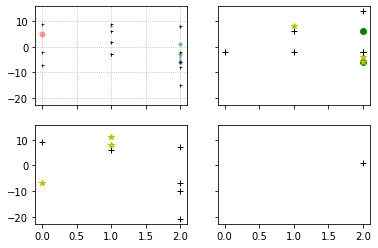

In [207]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True)
kk=fl[( (fl['Q']==1) & (fl['DD']!=0) &  (fl['DD_massless']<3) )].sort_values(['DD_massless','n'])
axs[0,0].plot( kk[kk['n']==6]['DD_massless'] ,kk[kk['n']==6]['DD'].str[0],'ro',markersize=6,markeredgewidth=0,alpha=0.4 )
axs[0,0].plot( kk[kk['n']==7]['DD_massless'] ,kk[kk['n']==7]['DD'].str[0],'go',markersize=4,markeredgewidth=0,alpha=0.5 )
axs[0,0].plot( kk[kk['n']==8]['DD_massless'] ,kk[kk['n']==8]['DD'].str[0],'b*',markersize=4,markeredgewidth=0.1,alpha=0.4)
axs[0,0].plot( kk[kk['n']==9]['DD_massless'] ,kk[kk['n']==9]['DD'].str[0],'k+',markersize=3,markeredgewidth=0.8,alpha=1 ) 
kk=fl[( (fl['Q']==1) & (fl['DM']!=0) &  (fl['DM_massless']<3) )].sort_values(['DM_massless','n'])
axs[0,1].plot( kk[kk['n']==6]['DM_massless'] ,kk[kk['n']==6]['DM'].str[0],'ro' )
axs[0,1].plot( kk[kk['n']==7]['DM_massless'] ,kk[kk['n']==7]['DM'].str[0],'go' )
axs[0,1].plot( kk[kk['n']==8]['DM_massless'] ,kk[kk['n']==8]['DM'].str[0],'y*')
axs[0,1].plot( kk[kk['n']==9]['DM_massless'] ,kk[kk['n']==9]['DM'].str[0],'k+' )
kk=fl[( (fl['Q']==1) & (fl['XD']!=0) &  (fl['XD_massless']<3) )].sort_values(['XD_massless','n'])
axs[1,0].plot( kk[kk['n']==6]['XD_massless'] ,kk[kk['n']==6]['XD'].str[0],'ro' )
axs[1,0].plot( kk[kk['n']==7]['XD_massless'] ,kk[kk['n']==7]['XD'].str[0],'go' )
axs[1,0].plot( kk[kk['n']==8]['XD_massless'] ,kk[kk['n']==8]['XD'].str[0],'y*')
axs[1,0].plot( kk[kk['n']==9]['XD_massless'] ,kk[kk['n']==9]['XD'].str[0],'k+' )
kk=fl[( (fl['Q']==1) & (fl['XM']!=0) &  (fl['XM_massless']<3) )].sort_values(['XM_massless','n'])
axs[1,1].plot( kk[kk['n']==6]['XM_massless'] ,kk[kk['n']==6]['XM'].str[0],'ro' )
axs[1,1].plot( kk[kk['n']==7]['XM_massless'] ,kk[kk['n']==7]['XM'].str[0],'go' )
axs[1,1].plot( kk[kk['n']==8]['XM_massless'] ,kk[kk['n']==8]['XM'].str[0],'y*')
axs[1,1].plot( kk[kk['n']==9]['XM_massless'] ,kk[kk['n']==9]['XM'].str[0],'k+' )
axs[0,0].grid(linestyle=':')
fig.savefig('kk.pdf')

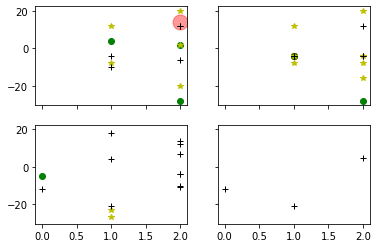

In [149]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True)
kk=fl6[( (fl6['Q']==1) & (fl6['DD']!=0) &  (fl6['DD_massless']<3) )].sort_values(['DD_massless','n'])
axs[0,0].plot( kk[kk['n']==6]['DD_massless'] ,kk[kk['n']==6]['DD'].str[0],'ro',markersize=15,alpha=0.4 )
axs[0,0].plot( kk[kk['n']==7]['DD_massless'] ,kk[kk['n']==7]['DD'].str[0],'go' )
axs[0,0].plot( kk[kk['n']==8]['DD_massless'] ,kk[kk['n']==8]['DD'].str[0],'y*')
axs[0,0].plot( kk[kk['n']==9]['DD_massless'] ,kk[kk['n']==9]['DD'].str[0],'k+' )
kk=fl6[( (fl6['Q']==1) & (fl6['DM']!=0) &  (fl6['DM_massless']<3) )].sort_values(['DM_massless','n'])
axs[0,1].plot( kk[kk['n']==6]['DM_massless'] ,kk[kk['n']==6]['DM'].str[0],'ro' )
axs[0,1].plot( kk[kk['n']==7]['DM_massless'] ,kk[kk['n']==7]['DM'].str[0],'go' )
axs[0,1].plot( kk[kk['n']==8]['DM_massless'] ,kk[kk['n']==8]['DM'].str[0],'y*')
axs[0,1].plot( kk[kk['n']==9]['DM_massless'] ,kk[kk['n']==9]['DM'].str[0],'k+' )
kk=fl6[( (fl6['Q']==1) & (fl6['XD']!=0) &  (fl6['XD_massless']<3) )].sort_values(['XD_massless','n'])
axs[1,0].plot( kk[kk['n']==6]['XD_massless'] ,kk[kk['n']==6]['XD'].str[0],'ro' )
axs[1,0].plot( kk[kk['n']==7]['XD_massless'] ,kk[kk['n']==7]['XD'].str[0],'go' )
axs[1,0].plot( kk[kk['n']==8]['XD_massless'] ,kk[kk['n']==8]['XD'].str[0],'y*')
axs[1,0].plot( kk[kk['n']==9]['XD_massless'] ,kk[kk['n']==9]['XD'].str[0],'k+' )
kk=fl6[( (fl6['Q']==1) & (fl6['XM']!=0) &  (fl6['XM_massless']<3) )].sort_values(['XM_massless','n'])
axs[1,1].plot( kk[kk['n']==6]['XM_massless'] ,kk[kk['n']==6]['XM'].str[0],'ro' )
axs[1,1].plot( kk[kk['n']==7]['XM_massless'] ,kk[kk['n']==7]['XM'].str[0],'go' )
axs[1,1].plot( kk[kk['n']==8]['XM_massless'] ,kk[kk['n']==8]['XM'].str[0],'y*')
axs[1,1].plot( kk[kk['n']==9]['XM_massless'] ,kk[kk['n']==9]['XM'].str[0],'k+' )

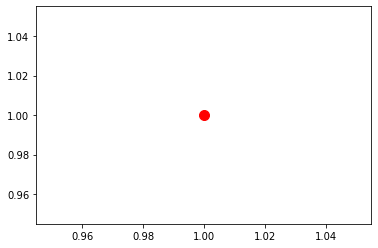

In [145]:
plt.plot(1,1,'ro',markersize=10)

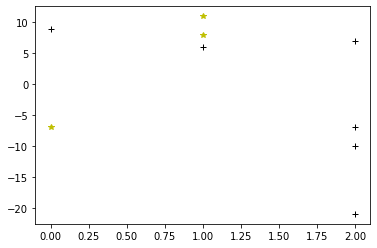

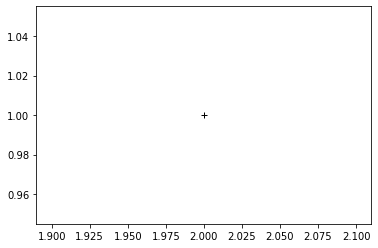

In [140]:
kk=fl[( (fl['Q']==1) & (fl['XM']!=0) &  (fl['XM_massless']<3) )].sort_values(['XM_massless','n'])
plt.plot( kk[kk['n']==6]['XM_massless'] ,kk[kk['n']==6]['XM'].str[0],'ro' )
plt.plot( kk[kk['n']==7]['XM_massless'] ,kk[kk['n']==7]['XM'].str[0],'go' )
plt.plot( kk[kk['n']==8]['XM_massless'] ,kk[kk['n']==8]['XM'].str[0],'y*')
plt.plot( kk[kk['n']==9]['XM_massless'] ,kk[kk['n']==9]['XM'].str[0],'k+' )

In [79]:
kk.reset_index(drop=True)

,n,l,k,gcd,solution,DD,DM,XD,XM,DD_massless,DM_massless,XD_massless,XM_massless,total,sltn_len,nu_R,unstable,Q
0,6,"[-1, -2]","[-1, 2]",1,"[1, 1, 1, -4, -4, 5]",0,[-4],0,0,10,1,10,10,16,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1
1,6,"[1, -2]","[-4, 1]",3,"[1, -4, -4, 9, 9, -11]",0,[-4],0,0,10,1,10,10,38,-1,"[{'D→nu_R+4fi': [-4, 1]}]",False,1
2,6,"[2, 1]","[-2, -1, 0]",1,"[1, -4, -8, 14, 14, -17]",[14],0,0,0,2,10,10,10,58,-1,"[{'D→nu_R+2fi+2fj': [-8, 1, 14]}]",False,1
3,7,"[1, -2, 1]","[-9, 6, 3]",1,"[1, 1, -4, -4, 7, 8, -9]",0,[-4],0,0,10,1,10,10,34,-2,"[{'D→nu_R+4fi': [-4, 1]}]",False,1
4,7,"[3, 1]","[-1, -5, 7]",1,"[2, 2, -4, 7, -8, -8, 9]",[2],[-8],0,0,2,3,10,10,40,-2,"[{'D→nu_R+2fi+2fj': [-8, 2, 7]}, {'D→nu_R+4fi': [-8, 2]}]",False,1
5,\boldsymbol{7},"[-3, -1]","[-2, -3, 1]",1,"[3, 3, 3, -5, -5, -7, 8]",0,0,[\boldsymbol{-5}],0,10,10,0,10,34,-1,"[{'X→nu_R+2fi+2fj': [-7, -5, 8]}]",False,1
6,7,"[-3, -4]","[-5, -7, -4]",2,"[4, 4, 5, -7, -8, -9, 11]",[4],0,0,0,1,10,10,10,48,-1,"[{'D→nu_R+2fi+2fj': [-7, 4, 5]}]",False,1
7,7,"[-1, -2]","[-8, -6, -7]",16,"[7, 10, -18, 25, -28, -28, 32]",[-28],[-28],0,0,2,2,10,10,148,-1,"[{'D→nu_R+4fi': [-28, 7]}, {'D→nu_R+2fi+2fj': [-28, -18, 32]}]",False,1
8,8,"[1, 2, -2]","[-7, 3, 0]",6,"[1, -7, -7, 17, 17, 19, -20, -20]",[-20],0,0,0,2,10,10,10,108,-3,"[{'D→nu_R+2fi+2fj': [-20, -7, 17]}]",False,1
9,8,"[1, 2, 1]","[-5, -10, -11]",1,"[1, 2, 2, 4, -5, -5, -7, 8]",[2],0,0,0,2,10,10,10,34,-2,"[{'D→nu_R+2fi+2fj': [-5, 2, 4]}]",False,1


In [91]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'extract']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
